In [2]:
import matplotlib.pyplot as plt
import math
import matplotlib.cm as cm
import scipy.constants
from math import pi, isinf
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings("ignore")

font = {'family': 'serif', 'size': 16}
plt.rc('font', **font)
plt.rc('text', usetex=True)

# Constants kb in the unit of kj/mol
GAS_CONSTANT = 8.314462618 * 10**(-3)

# Using S0 method to compute the activity coeffients of ethanol & water at varying mole fractions.

# The chemical potential is calculated from
$$
\left(\frac{\partial \mu_A}{\partial \ln x_A}\right)_{T, P}=\frac{k_B T}{x_B S_{A A}^0 + x_A S_{B B}^0 -  2 \sqrt{x_A x_B} S_{A B}^0}
$$
### in which the error estimation for this integrand is based on:
$$
\sigma_{\rm{integrand}} = \sqrt{\frac{x_A^2 \sigma_{S_{A A}}^2 + 4 x_A x_B  \sigma_{S_{A B}}^2 + x_B^2 \sigma_{S_{B B}}^2}{(x_A {S_{A A}} + x_B {S_{B B}}  -  2 \sqrt{x_A x_B} S_{A B}^0)^4}}
$$

## Since the activity coeffients $\gamma$ takes the form of:
$$
\gamma = \frac{e^{\frac{\mu}{k_{\rm B} T}}}{x}
$$
### so that the error propogation in computing $\gamma$ becomes 
$$
\sigma_{\gamma}  = \sigma_{\mu} \frac{\gamma}{k_{\rm B} x}
$$


In [3]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import quad


def get_betadmua_dlnxa(saa: float, sab: float, sbb: float, xa: float) -> float:
    """
    Calculate the derivative of beta_mu_a with respect to ln(x_a).

    Parameters:
    saa (float): Parameter S_AA
    sab (float): Parameter S_AB
    sbb (float): Parameter S_BB
    xa (float): Mole fraction of component A

    Returns:
    float: The derivative of beta_mu_a with respect to ln(x_a)
    """
    xb = 1.0 - xa
    return 1.0 / (xb * saa + xa * sbb - 2 * (xa * xb) ** 0.5 * sab)

def mu_mol_frac(saa: np.ndarray, sab: np.ndarray, sbb: np.ndarray, xa: np.ndarray, x0: float, kbT: float) -> np.ndarray:
    """
    Calculate the integral of a function and its error.

    Parameters:
    saa, sab, sbb (np.ndarray): 2D arrays with shape (2, N), where the first row is S and the second row is S_error.
    xa (np.ndarray): 1D array with N elements.
    x0 (float): A constant.
    kbT (float): Boltzmann constant times temperature.

    Returns:
    np.ndarray: A 2D array where each row is [x_a, mu, mu_error].
    """
    logxa = np.log(xa)

    integrand = get_betadmua_dlnxa(saa[:,0],sab[:,0],sbb[:,0],xa)
    integrand_error = np.sqrt((xa**2*saa[:,1]**2 + 4*xa*(1-xa)*sab[:,1]**2 + 
                               (1-xa)**2*sbb[:,1]**2)/(xa*saa[:,0] + (1-xa)*sbb[:,0] - 2*sab[:,0]*(xa*(1-xa))**0.5)**4)   

    mask = ~np.isnan(integrand)
    int_func = interp1d(logxa[mask], integrand[mask], kind='linear',fill_value='extrapolate')
    int_error_func = interp1d(logxa[mask], integrand_error[mask], kind='linear',fill_value='extrapolate')

    # Calculate the integral using list comprehension
    x_mu_dataset = []
    for i, a in enumerate(logxa):
        mu_now = kbT * quad(int_func, np.log(x0), a)[0]
        mu_error_now = kbT * quad(int_error_func, np.log(x0), a)[0]
        mu_error_now /= np.sqrt(i) if i >= 1 else 1
        x_mu_dataset.append([xa[i], mu_now, abs(mu_error_now)])
    
    return np.asarray(x_mu_dataset)

def read_data(file_path: str) -> tuple:
    """
    Read a data file and extract several columns into numpy arrays.

    Parameters:
    file_path (str): The path to the data file.

    Returns:
    tuple: A tuple containing numpy arrays for x_eth, x_water, S_AA, S_AB, and S_BB.
    """
    data = pd.read_csv(file_path, sep=' ', skiprows=9, 
                       names=["x", "AA", "AA_err", "AB", "AB_err", "BB", "BB_err"], engine='python')
    x_eth = data['x'].values
    x_water = 1 - x_eth

    S_AA = data[['AA', 'AA_err']].values
    S_AB = data[['AB', 'AB_err']].values
    S_BB = data[['BB', 'BB_err']].values
    
    return x_eth, x_water, S_AA, S_AB, S_BB
    

def process_data_gamma(file_path: str, T: float) -> tuple:
    """
    Process data from a file and calculate gamma values.

    Parameters:
    file_path (str): The path to the data file.
    T (float): Temperature.

    Returns:
    tuple: A tuple containing numpy arrays for x_eth, gamma_eth_sum, and gamma_water_sum.
    """
    x_eth, x_water, S_AA, S_AB, S_BB = read_data(file_path)

    kbT = GAS_CONSTANT * T 
    excess_mu_eth_part = mu_mol_frac(S_AA, S_AB, S_BB, x_eth, 1, kbT)
    excess_mu_water_part = mu_mol_frac(S_BB, S_AB, S_AA, x_water, 1, kbT)

    # Calculate gamma and gamma_err in a single step
    gamma_eth, gamma_eth_err = np.exp(excess_mu_eth_part[:, 1] / kbT) / x_eth, excess_mu_eth_part[:, 2] / kbT * np.exp(excess_mu_eth_part[:, 1] / kbT)
    gamma_eth_sum = np.column_stack((gamma_eth, gamma_eth_err))
    
    gamma_water, gamma_water_err = np.exp(excess_mu_water_part[:, 1] / kbT) / x_water, excess_mu_water_part[:, 2] / kbT * np.exp(excess_mu_water_part[:, 1] / kbT)
    gamma_water_sum = np.column_stack((gamma_water, gamma_water_err))
    
    return x_eth, gamma_eth_sum, gamma_water_sum

Now we include the part of vapor pressure 
The vapor pressure at any given temeperature is 

$$ \sqrt{\frac{\left(H^{2} T^{2} \sigma_{T b}^{2} + T_{b}^{2} \sigma_{H}^{2} \left(T - T_{b}\right)^{2}\right) e^{\frac{2 H \left(T - T_{b}\right)}{R T T_{b}}}}{R^{2} T^{2} T_{b}^{4}}} $$

In [4]:
# Thermodynamic data and experimental boiling points for ethanol and water

DeltaH_eth =  42.3 # Enthalpy change for ethanol, in kJ/mol
DeltaH_eth_error = 0.4 # Error in enthalpy change for ethanol
Tb_eth = 351.5 # Boiling point of ethanol, in K
Tb_eth_error = 0.2 # Error in boiling point of ethanol

DeltaH_water =  40.65 # Enthalpy change for water, in kJ/mol
DeltaH_water_error = 0.0 # Error in enthalpy change for water
Tb_water = 373.15 # Boiling point of water, in K
Tb_water_error = 0.0 # Error in boiling point of water

# Function to calculate the saturated vapor pressure of ethanol
def cal_P_vapor_eth(T):
    # Using the Clausius–Clapeyron equation to calculate saturated vapor pressure
    P_vap  = math.exp(DeltaH_eth / GAS_CONSTANT * (1/Tb_eth - 1/T)) 
    # Using error propagation formula to calculate the error in saturated vapor pressure
    P_vap_err = math.sqrt(((DeltaH_eth**2*Tb_eth_error**2*T**2+DeltaH_eth_error**2*Tb_eth**2*(Tb_eth-T)**2)*P_vap**2)/(GAS_CONSTANT**2*T**2*Tb_eth**4))
    return  P_vap, P_vap_err

# Function to calculate the saturated vapor pressure of water
def cal_P_vapor_water(T):
    # Using the Clausius–Clapeyron equation to calculate saturated vapor pressure
    P_vap  = math.exp(DeltaH_water / GAS_CONSTANT * (1/Tb_water - 1/T)) 
    # Using error propagation formula to calculate the error in saturated vapor pressure
    P_vap_err = math.sqrt(((DeltaH_water**2*Tb_water_error**2*T**2+DeltaH_water_error**2*Tb_water**2*(Tb_water-T)**2)*P_vap**2)/(GAS_CONSTANT**2*T**2*Tb_water**4))
    return  P_vap, P_vap_err

Text(0, 0.5, 'Temperature (K)')

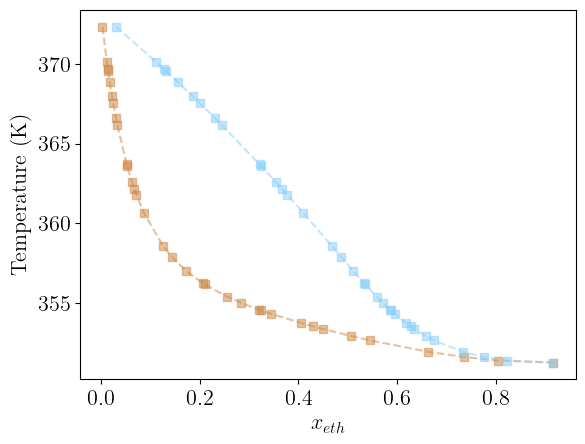

In [5]:
# Experimental data      
Xexp = [0.0028, 0.0118, 0.0137, 0.0144, 0.0176, 0.0222, 0.0246, 0.0302, 0.0331, 0.0519, 0.053, 0.0625, 0.0673, 0.0715, 0.0871, 0.126, 0.143, 0.172, 0.206, 0.21, 0.255, 0.284, 0.321, 0.324, 0.345, 0.405, 0.43, 0.449, 0.506, 0.545, 0.663, 0.735, 0.804, 0.917]
Yexp = [0.030032747114167264, 0.1119165227569313, 0.12681035030511342, 0.1321161804758278, 0.15521069658462644, 0.1853832798762436, 0.199863950198681, 0.23072015425136494, 0.2452611356185893, 0.32122466320484533, 0.3248767546541161, 0.3536193897185803, 0.3664610907894552, 0.37690058407693994, 0.4102520029988656, 0.46812348247133073, 0.4862207624940885, 0.5109554780833073, 0.5334326481434359, 0.5357505985278852, 0.5586666832805004, 0.5713244750112599, 0.5861581262043974, 0.5873193592441576, 0.5953404241081481, 0.6178766006210084, 0.627383677899266, 0.6347393214203467, 0.6578001087446734, 0.6746966227595217, 0.7332997721555606, 0.7759786833524904, 0.8229867190849519, 0.9159008055271933]
Tuniquac = [372.34039323525707, 370.1034981182889, 369.68155169629006, 369.53006056990654, 368.8633336279051, 367.9738169022553, 367.53927355444455, 366.5962973029042, 366.14371154914164, 363.6911081932032, 363.5694169289356, 362.5996967832958, 362.1596960984029, 361.79903681913447, 360.63019021490896, 358.557104145122, 357.90498979101994, 357.02115163303506, 356.23692682201323, 356.15769304798266, 355.3981991772244, 355.0021513007638, 354.56479115613183, 354.5318886191019, 354.3102017331324, 353.74131688246143, 353.52539252412436, 353.36790610139997, 352.92563405422317, 352.6474318369349, 351.93166713528876, 351.60268936140676, 351.38029693761854, 351.2527732181329]

# Plotting the data
plt.plot(Xexp,Tuniquac, marker='s', alpha = 0.5, \
        c='peru', ls = "--", label="Experimental data at 1.0 bar ")
plt.plot(Yexp,Tuniquac, marker='s',alpha = 0.5, \
        c='lightskyblue', ls = "--", label="Experimental data at 1.0 bar")

plt.xlabel(r'$x_{eth}$')
plt.ylabel('Temperature (K)')


In [6]:
temperatures = [347, 350, 351, 352, 355, 360, 365, 367, 368, 370]
file_paths = [f"/Gromacs results/Liq_{T}K_1bar_gmx_trappeUA.txt" for T in temperatures]


# Use dictionary comprehension to store the results
x_eth_dataset = {}
gamma_eth_dataset = {}
gamma_water_dataset = {}

# Loop over each temperature and file path
for T, file_path in zip(temperatures, file_paths):
      x_eth_dp, gamma_eth_dp, gamma_water_dp = process_data_gamma(file_path, T)
      x_eth_dataset[T] = x_eth_dp
      gamma_eth_dataset[T] = gamma_eth_dp
      gamma_water_dataset[T] = gamma_water_dp

# Fitting

In [7]:
from scipy.interpolate import SmoothBivariateSpline

# Prepare the data
T_values = []
x_values = []
gamma_eth_values = []
gamma_water_values = []

for T in temperatures:
    for x, gamma_eth, gamma_water  in zip(x_eth_dataset[T], gamma_eth_dataset[T], gamma_water_dataset[T]):
        T_values.append(T)
        x_values.append(x)
        gamma_eth_values.append(gamma_eth)
        gamma_water_values.append(gamma_water)

# Convert lists to numpy arrays
T_values = np.array(T_values)
x_values = np.array(x_values)
gamma_eth_values = np.array(gamma_eth_values)[:,0]
gamma_water_values = np.array(gamma_water_values)[:,0]

# Create the interpolation function
gamma_eth_func = SmoothBivariateSpline(T_values, x_values, gamma_eth_values)
gamma_water_func = SmoothBivariateSpline(T_values, x_values, gamma_water_values)

# Use gamma_eth_func to get interpolated values of gamma_eth for any T and x
T_sampled = np.linspace(348, 360, 30)
x_sampled = np.linspace(0, 1, 101)

for T in T_sampled:
    P_vap_eth = cal_P_vapor_eth(T)[0]
    P_vap_water = cal_P_vapor_water(T)[0]
    for x  in x_sampled:
        gamma_eth = gamma_eth_func(T, x)
        gamma_water = gamma_water_func(T, x)
        measure  = GAS_CONSTANT*(np.log(gamma_eth)/DeltaH_eth - np.log(gamma_water)/DeltaH_water) + (1/Tb_eth - 1/ Tb_water)
        
        P_vap_total = gamma_eth * P_vap_eth * x + gamma_water * P_vap_water * (1 - x)
        
        y = gamma_eth * P_vap_eth * x / P_vap_total
        y = y[0][0]

        if abs(measure) <= 5e-5 and abs(P_vap_total - 1.0) <= 2e-4 and abs(y - x) <= 1e-2:
            T_azeotrope = T
            x_azeotrope = x
            y_azeotrope = y
            print(f'The value of x {x:2f}; The value of y {y:2f} at T = {T:2f} K')


The value of x 0.890000; The value of y 0.882596 at T = 350.482759 K


# To make the phase diagram

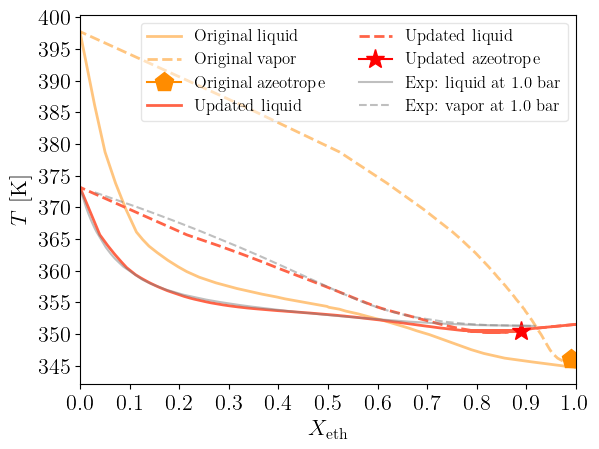

In [8]:
# Define a range of temperatures and compositions to sample
T_sampled = np.linspace(T_azeotrope-2, Tb_water+2, 500)
x_sampled = np.linspace(0, 1, 500)

# Initialize an empty list to store the data
data_set = []

# Loop over each temperature
for T in T_sampled:
    # Calculate the vapor pressures of ethanol and water at this temperature
    P_vap_eth = cal_P_vapor_eth(T)
    P_vap_water = cal_P_vapor_water(T)
    
    # Loop over each composition
    for x  in x_sampled:
        # Calculate the activity coefficients of ethanol and water at this temperature and composition
        gamma_eth = gamma_eth_func(T, x)
        gamma_water = gamma_water_func(T, x)
        
        # Calculate the total vapor pressure
        P_vap_total = gamma_eth * P_vap_eth * x + gamma_water * P_vap_water * (1 - x) 

        # Calculate the vapor phase composition of ethanol
        y = gamma_eth * P_vap_eth * x / P_vap_total
        
        # If the total pressure is close to 1.0 bar, store the temperature, liquid phase composition, and vapor phase composition
        if abs(P_vap_total[:,0] - 1.0) <= 2e-4 :
            data_set.append(np.array([T, x, y[:,0][0]]))

# Convert the list of data to a numpy array
data_set = np.array(data_set)        

# Filter the data to only include compositions less than the azeotropic composition
mask = (0.02 < data_set[:, 1]) & (data_set[:, 1] < x_azeotrope)
left_data_set = data_set[mask]

# Add the boiling points of ethanol and water to the data
left_data_set = np.insert(left_data_set, 0, [Tb_eth, 1.0, 1.0], axis=0)
left_data_set = np.append(left_data_set, [[Tb_water, 0, 0]], axis=0)

# Filter the data to only include compositions greater than the azeotropic composition
mask = (0.99 < data_set[:, 1]) & (data_set[:, 1] > x_azeotrope)
right_data_set = data_set[mask]

# Add the boiling point of ethanol to the data
right_data_set = np.append(right_data_set, [[Tb_eth, 1.0, 1.0]], axis=0)
right_data_set = np.delete(right_data_set, 1, axis=0)

# Load the raw data from a CSV file
data_set = np.loadtxt("raw_dataset_water_ethanol.csv", delimiter=",", skiprows=1)

# Convert the numpy array to a pandas DataFrame
df = pd.DataFrame(data_set)

# Apply a moving average smoothing
window_size = 3  # Choose an appropriate window size
df_smoothed = df.rolling(window_size, center=True).mean()

# Replace NaN values (at the start and end of the data) with the original data
df_smoothed.fillna(df, inplace=True)
data_set = df_smoothed.to_numpy()

# Plot the original and smoothed data
plt.plot(data_set[::,1], data_set[::,0], marker='none', linewidth=2.0, alpha=0.5,\
        c='darkorange', ls = "-", label="Original liquid")
plt.plot(data_set[::,2], data_set[::,0], marker='none', linewidth=2.0, alpha

In [9]:
# Concatenate the two data sets along the first axis
S0_EXP_data = np.concatenate((left_data_set, right_data_set), axis=0)
S0_EXP_data = sorted(S0_EXP_data, key=lambda x: x[1])

S0_MD_data = data_set
S0_MD_azeotrope = [346, 0.99, 0.01]
S0_EXP_azeotrope = [T_azeotrope, x_azeotrope, y_azeotrope]

EXP_azeotrope = [351.5, 0.89, 1-0.89]


import pandas as pd

# data dictionary
data = {
    'S0_EXP_T': pd.Series(row[0] for row in S0_EXP_data),
    'S0_EXP_liq': pd.Series(row[1] for row in S0_EXP_data),
    'S0_EXP_vap': pd.Series(row[2] for row in S0_EXP_data),
    'S0_MD_T': pd.Series(S0_MD_data[:, 0]),
    'S0_MD_liq': pd.Series(S0_MD_data[:, 1]),
    'S0_MD_vap': pd.Series(S0_MD_data[:, 2]),
    'S0_EXP_azeotrope': pd.Series(S0_EXP_azeotrope),
    'S0_MD_azeotrope': pd.Series(S0_MD_azeotrope),
    'EXP_T': pd.Series(Tuniquac),
    'EXP_liq': pd.Series(Xexp),
    'EXP_vap': pd.Series(Yexp),
    'EXP_azeotrope': pd.Series(EXP_azeotrope)
}

# pandas DataFrame
df = pd.DataFrame(data)

# DataFrame to CSV
df.to_csv('ethanol_water_data.csv')


In [10]:
from scipy.interpolate import SmoothBivariateSpline

# Prepare the data
T_values = []
x_values = []
gamma_eth_values = []
gamma_water_values = []

for T in temperatures:
    for x, gamma_eth, gamma_water  in zip(x_eth_dataset[T], gamma_eth_dataset[T], gamma_water_dataset[T]):
        T_values.append(T)
        x_values.append(x)
        gamma_eth_values.append(gamma_eth)
        gamma_water_values.append(gamma_water)

# Convert lists to numpy arrays
T_values = np.array(T_values)
x_values = np.array(x_values)
gamma_eth_values = np.array(gamma_eth_values)
gamma_water_values = np.array(gamma_water_values)

# MC parts, number of synthetic datasets to create
N = 1000
solver_results = []

for i in range(N):
    DeltaH_eth_synthetic = DeltaH_eth + DeltaH_eth_error*np.random.uniform(-1, 1)
    DeltaH_water_synthetic = DeltaH_water + DeltaH_water_error*np.random.uniform(-1, 1)
    Tb_eth_synthetic = Tb_eth + Tb_eth_error*np.random.uniform(-1, 1)
    Tb_water_synthetic = Tb_water + Tb_water_error*np.random.uniform(-1, 1)
    
    # Create the interpolation function
    gamma_eth_synthetic   = gamma_eth_values[:,0]   + gamma_eth_values[:,1]*np.random.uniform(-1, 1)
    gamma_water_synthetic = gamma_water_values[:,0] + gamma_water_values[:,1]*np.random.uniform(-1, 1)
    
    gamma_eth_func = SmoothBivariateSpline(T_values, x_values, gamma_eth_synthetic)
    gamma_water_func = SmoothBivariateSpline(T_values, x_values, gamma_water_synthetic)
    
    
    # parameter space 
    T_sampled = np.linspace(348, 360, 50)
    x_sampled = np.linspace(0, 1, 101)
    
    for T in T_sampled:
        P_vap_eth_synthetic  = cal_P_vapor_eth(T)[0] + cal_P_vapor_eth(T)[1]*np.random.uniform(-1, 1)
        P_vap_water_synthetic = cal_P_vapor_water(T)[0] + cal_P_vapor_water(T)[1]*np.random.uniform(-1, 1)
        for x in x_sampled:
            gamma_eth = gamma_eth_func(T, x)
            gamma_water = gamma_water_func(T, x)
            measure  = GAS_CONSTANT*(np.log(gamma_eth)/DeltaH_eth_synthetic - np.log(gamma_water)/DeltaH_water_synthetic) + (1/Tb_eth_synthetic - 1/ Tb_water_synthetic)
            
            P_vap_total = gamma_eth * P_vap_eth_synthetic * x + gamma_water * P_vap_water_synthetic * (1 - x)
            
            y = gamma_eth * P_vap_eth_synthetic * x / P_vap_total
            y = y[0][0]
    
            if abs(measure) <= 5e-5 and abs(P_vap_total - 1.0) <= 2e-4 and abs(y - x) <= 1e-2:
                solver_results.append([T, x, y]) #T_azeotrope, x_azeotrope, y_azeotrope

                
solver_results = np.array(solver_results)
solver_results_non_zero_mean = solver_results.mean(axis=0)
solver_results_non_zero_std = solver_results.std(axis=0)

# Save the data in a txt file
np.savetxt('solver_results_mean.txt', solver_results_non_zero_mean)
np.savetxt('solver_results_std.txt', solver_results_non_zero_std)

KeyboardInterrupt: 

# Error estimation
# After 1e6 MC steps, the random sampling reports:
# Water-ethanol 1 bar
## T_azeotrope = 350.84 $\pm$ 0.71 K
## X_eth = 89.3 $\pm$ 0.06 mol%


## experimental value: 351.55 K, 89 mol% ethanol + 11 mol% water
## previous simulations: fix T = 351 K, report that 90 mol% ethanol + 10 mol% water